In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from pymc_marketing import clv
sns.set_style('darkgrid')
%matplotlib inline
pd.options.display.max_rows = 10

In [ ]:
#%pip install git+https://github.com/pymc-labs/pymc-marketing.git

There are two business dimensions that influence how a data scientist should go about modeling customer lifetime value:

* Whether purchases are discrete (i.e., transactions can occur only at fixed points in time) or continuous.

* Whether the setting is contractual or non-contractual (this determines whether customer churn is visible or must be inferred).

In this example I'll assume that we have a contractual, discrete time setting and use the SBG ("shifted-beta-geometric") model.

Some relevant models for the other three cases are:
* For continuous-time contractual settings, we have the exponential-gamma (EG) model.
* For continuous-time noncontractual settings, we have the Pareto/NBD (Schmittlein, Morrison, & Colombo, 1987) and BG/ NBD (Fader, Hardie, & Lee, 2005) models.
* For discrete-time noncontractual settings, we have the BG/BB model (Fader, Hardie, & Berger, 2004).

In [7]:
# Creating dataset
df = pd.DataFrame({
    "regular": [100.0, 63.1, 46.8, 38.2, 32.6, 28.9, 26.2, 24.1, 22.3, 20.7, 19.4, 18.3, 17.3],
    "highend": [100.0, 86.9, 74.3, 65.3, 59.3, 55.1, 51.7, 49.1, 46.8, 44.5, 42.7, 40.9, 39.4],
})
df

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
...,...,...
8,22.3,46.8
9,20.7,44.5
10,19.4,42.7
11,18.3,40.9


In [15]:
# PyMC requires individual-level observations. We create a synthetic dataset that respects the aggregate group trends in df.
def individual_data_from_percentage_alive(percentage_alive, initial_customers):
    n_alive = np.asarray(percentage_alive / 100 * initial_customers, dtype=int)
    
    died_at = np.zeros((initial_customers,), dtype=int)
    counter = 0
    for t, diff in enumerate((n_alive[:-1] - n_alive[1:]), start=1):
        died_at[counter:counter+diff] = t
        counter += diff

    censoring_t = t+1
    died_at[counter:] = censoring_t
    
    return died_at

In [16]:
T = 8  # In the paper only the first 7 years are included in the model

truncated_df = df[:T]
initial_customers = 1000  # Seems to be what F&H use, according to Appendix B
churn_highend = individual_data_from_percentage_alive(truncated_df["highend"], initial_customers)
churn_regular = individual_data_from_percentage_alive(truncated_df["regular"], initial_customers)
churn_regular[::10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
# Fitting the sBG models for high end and regular users
highend_users = clv.ShiftedBetaGeoModelIndividual(
    customer_id = np.arange(initial_customers),
    t_churn = churn_highend,
    T = T,
)
highend_users

Shifted-Beta-Geometric Model (Individual Customers)
         alpha ~ HalfFlat()
          beta ~ HalfFlat()
         theta ~ Beta(alpha, beta)
churn_censored ~ Censored(Geometric(theta), -inf, 8)

In [22]:
regular_users = clv.ShiftedBetaGeoModelIndividual(
    customer_id = np.arange(initial_customers),
    t_churn = churn_regular,
    T = T,
)
regular_users

Shifted-Beta-Geometric Model (Individual Customers)
         alpha ~ HalfFlat()
          beta ~ HalfFlat()
         theta ~ Beta(alpha, beta)
churn_censored ~ Censored(Geometric(theta), -inf, 8)

In [23]:
highend_users.fit()
regular_users.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [24]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.704, 3.806],
    "regular": [0.688, 1.182],
}
highend_users.fit_summary(var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.736,0.129,0.531,0.991,0.014,0.010,91.0,169.0,1.04
beta,4.346,0.997,2.581,6.142,0.103,0.073,96.0,167.0,1.04


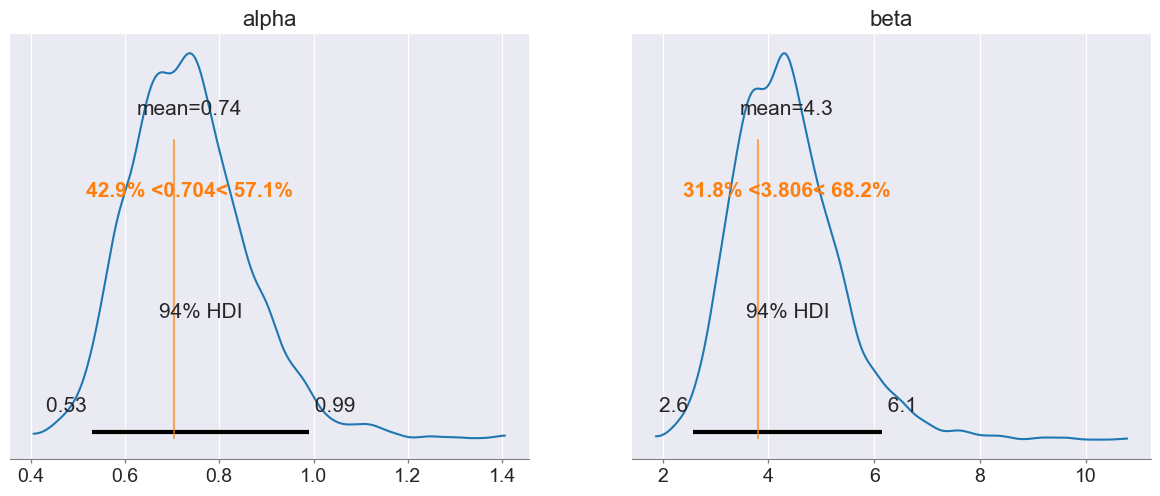

In [25]:
import arviz as az
az.plot_posterior(
    highend_users.fit_result, 
    var_names=["alpha", "beta"],
    ref_val=ref_val["highend"]
);

In [26]:
regular_users.fit_summary(var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.719,0.068,0.598,0.848,0.004,0.003,301.0,805.0,1.01
beta,1.218,0.157,0.949,1.529,0.009,0.007,284.0,578.0,1.01


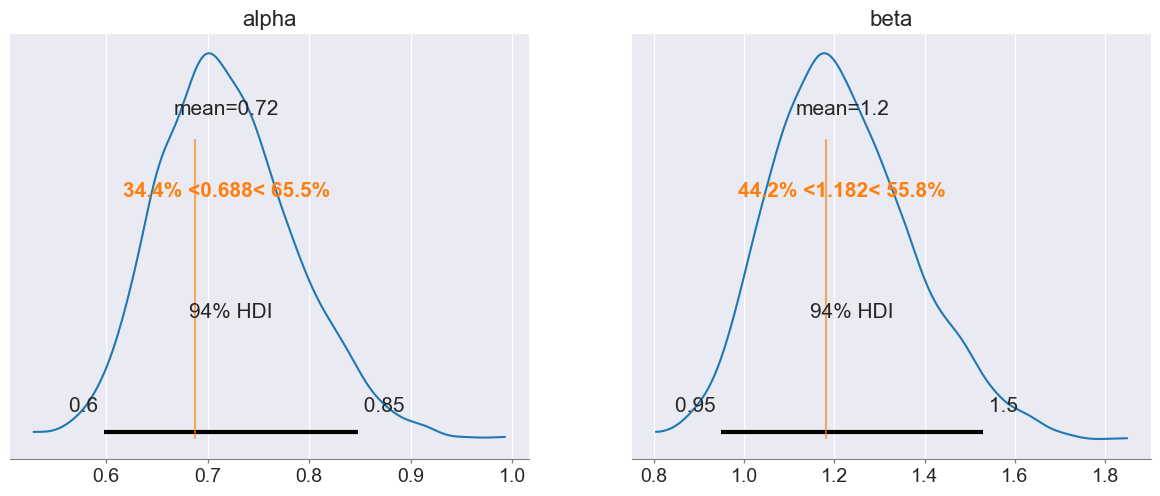

In [27]:
az.plot_posterior(
    regular_users.fit_result, 
    var_names=["alpha", "beta"],
    ref_val=ref_val["regular"]
);

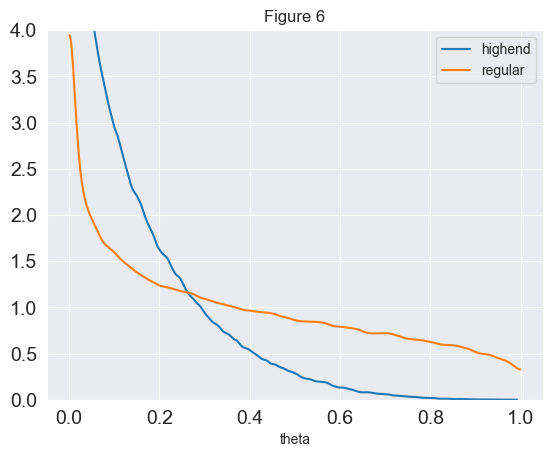

In [38]:
# Theta distributions
new_highend_theta = highend_users.distribution_new_customer_theta(n=100)
new_regular_theta = regular_users.distribution_new_customer_theta(n=100)

ax = az.plot_dist(new_highend_theta, label="highend")
ax = az.plot_dist(new_regular_theta, label="regular", ax=ax, color="C1")
ax.set_xlabel("theta")
plt.ylim([0, 4])
ax.set_title("Figure 6");

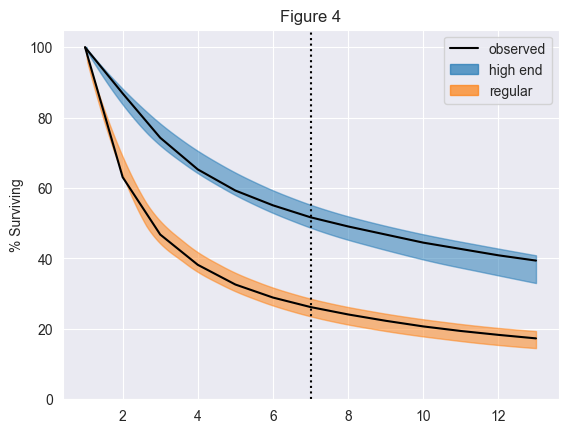

In [47]:
# Survival curves
churn_highend = highend_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers)
)
churn_regular = regular_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers)
)

import xarray as xr
weeks = xr.DataArray(np.arange(1, 14), dims=["weeks"])

survival_perc_highend = 100-100*((churn_highend < weeks))
survival_perc_regular = 100-100*((churn_regular < weeks))

az.plot_hdi(weeks, survival_perc_highend.mean("customer_id"), hdi_prob=.95, color="C0")
az.plot_hdi(weeks, survival_perc_regular.mean("customer_id"), hdi_prob=.95, color="C1")

plt.plot(weeks, df["highend"], color="k", label="observed")
plt.plot(weeks, df["regular"], color="k")

plt.axvspan(None, None, color="C0", alpha=0.7, label="high end")
plt.axvspan(None, None, color="C1", alpha=0.7, label="regular")

plt.axvline(7, ls=':', color="k")
plt.ylim([0, 105])
plt.ylabel("% Surviving")
plt.legend()
plt.title("Figure 4");

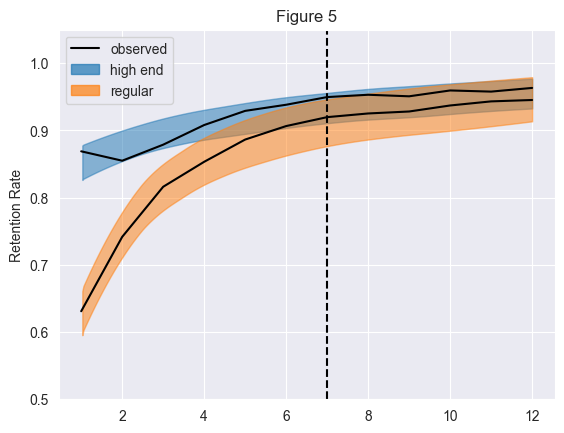

In [48]:
# Retention rates
retention_rate_highend = (
    survival_perc_highend.isel(weeks=slice(1, None, None)) 
    / survival_perc_highend.isel(weeks=slice(None, -1, None))
)
retention_rate_regular = (
    survival_perc_regular.isel(weeks=slice(1, None, None)) 
    / survival_perc_regular.isel(weeks=slice(None, -1, None))
)

retention_rate_highend_obs = df["highend"][1:].values / df["highend"][:-1].values
retention_rate_regular_obs = df["regular"][1:].values / df["regular"][:-1].values

weeks_ = weeks[:-1]

az.plot_hdi(weeks_, retention_rate_highend.mean("customer_id"), hdi_prob=.95, color="C0")
az.plot_hdi(weeks_, retention_rate_regular.mean("customer_id"), hdi_prob=.95, color="C1")

plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
plt.plot(weeks_, retention_rate_regular_obs, color="k")

plt.axvspan(None, None, color="C0", alpha=0.7, label="high end")
plt.axvspan(None, None, color="C1", alpha=0.7, label="regular")

plt.axvline(7, ls='--', color="k")
plt.ylim([0.5, 1.05])
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Figure 5");